In [2]:
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import numpy as np

#### 5a. Plot Lightcurve and Identify Intervals

First, I will load and plot the corrected lightcurve to visually define the time intervals.

<IPython.core.display.Javascript object>

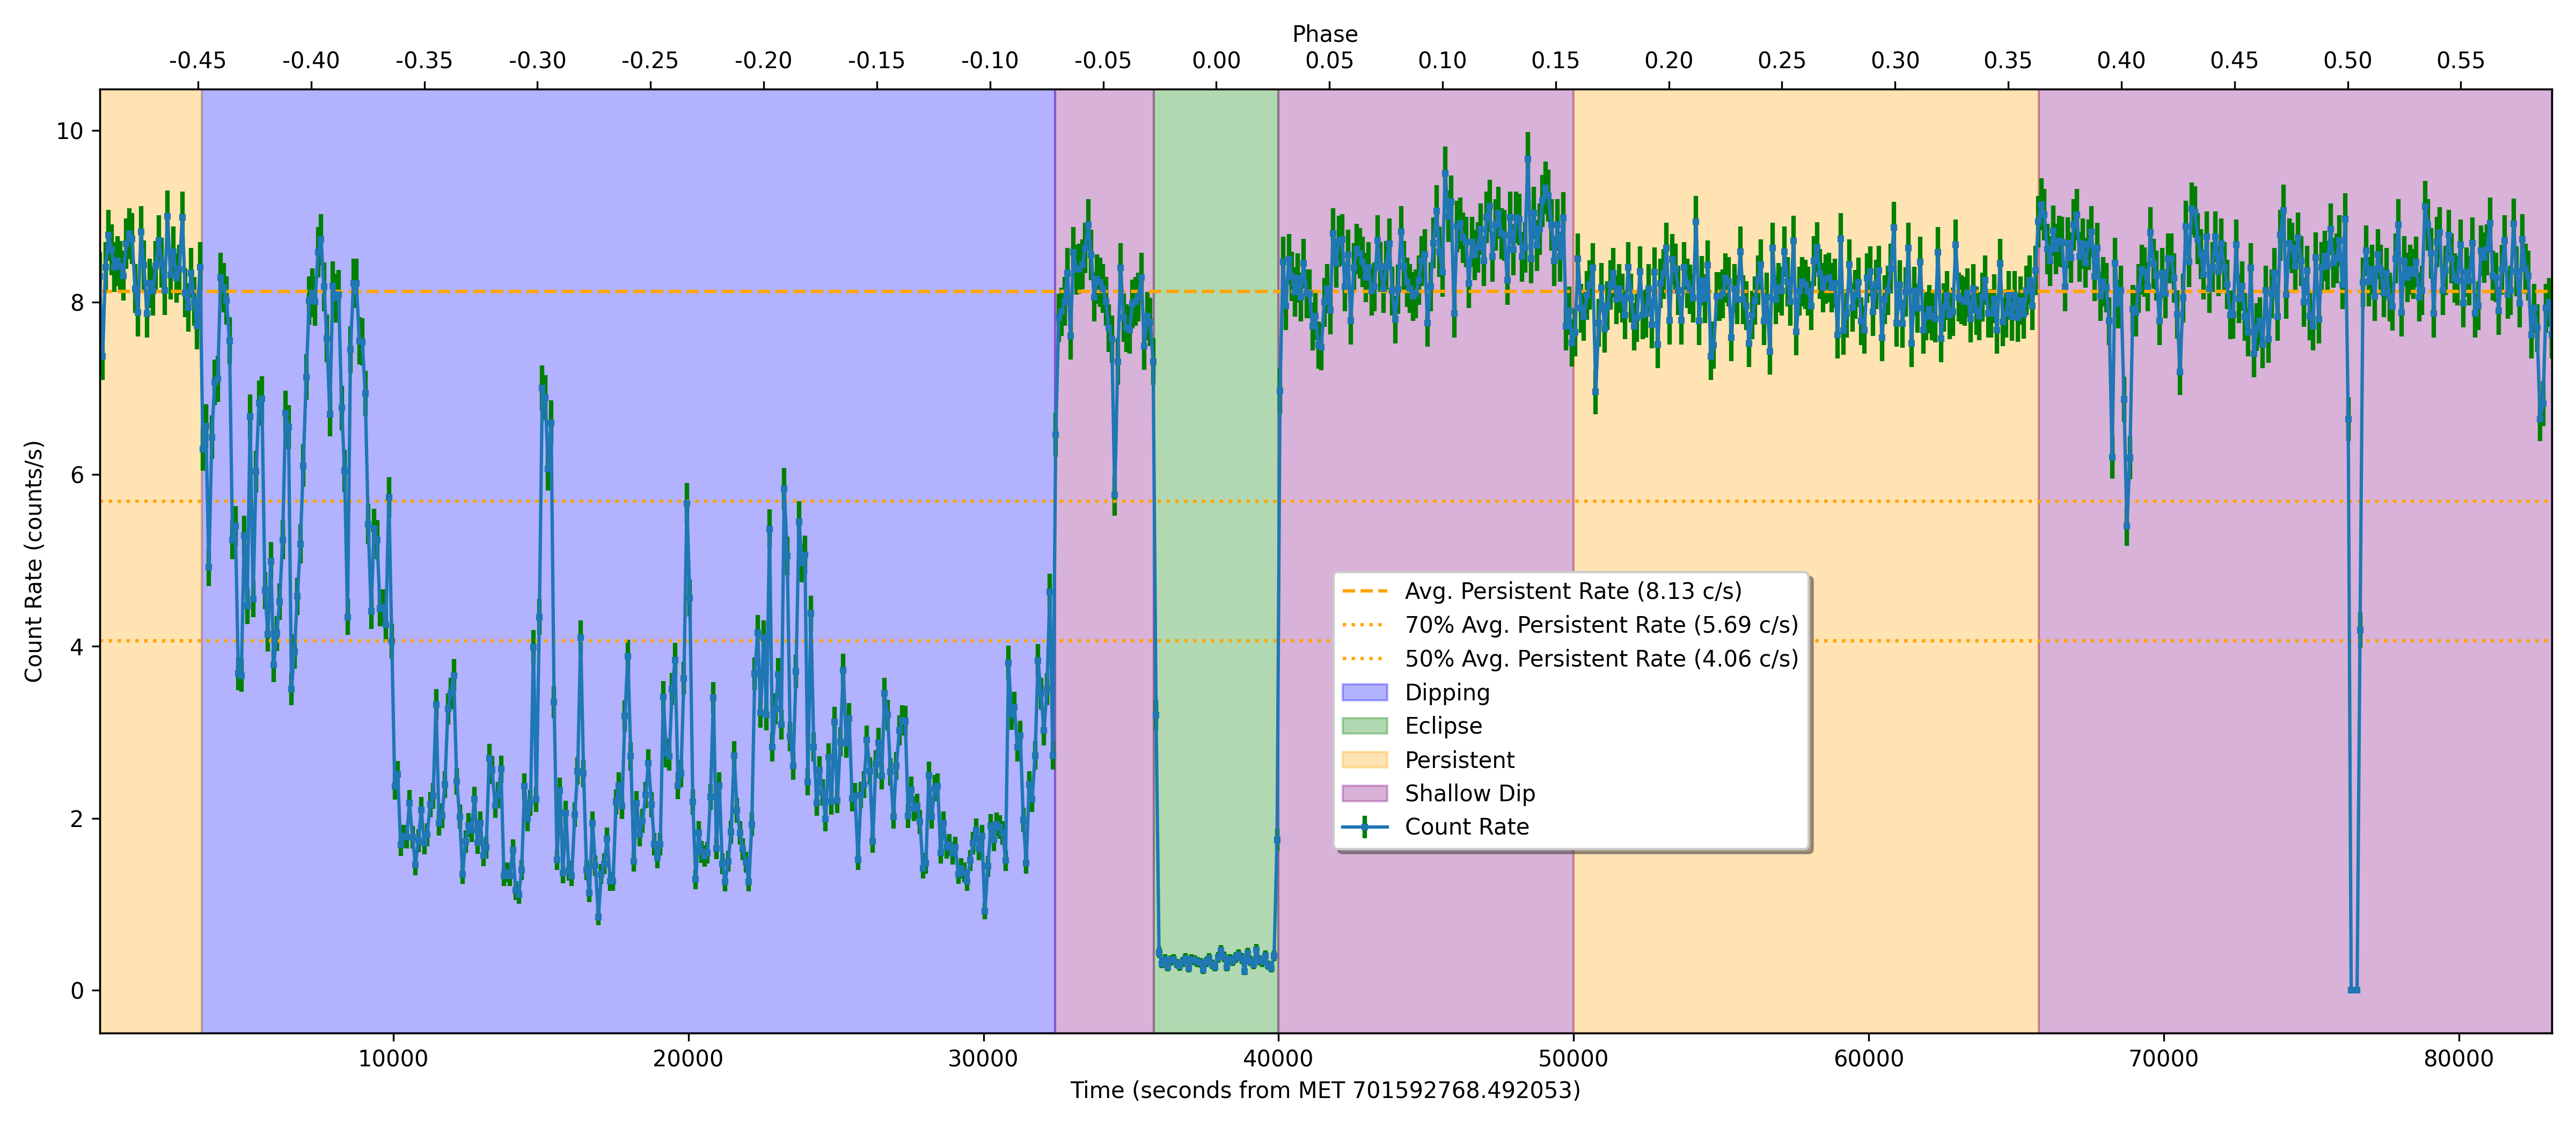

4.06378238341969 5.689295336787565


In [3]:
# Get Project Root and ObsID from the environment
%matplotlib notebook
os.environ['PROJECT_ROOT'] = '/media/kyle/kyle_phd/Swift-j1858.6-0814/'
os.environ['OBSID'] = '/0865600201'
project_root = os.environ.get('PROJECT_ROOT')
obsid = os.environ.get('OBSID')

# Define path to the raw lightcurve
lc_file_path = f"{project_root}/products/{obsid}/pn/lc/pn_source_lc_raw.fits"

# Read the RATE table to get time and rate columns
with fits.open(lc_file_path) as hdul:
    lc_table = Table(hdul[1].data)
# Extract time and rate
time = lc_table['TIME'] # This is in MET
rate = lc_table['RATE']

# Get the observation start time from the header
with fits.open(lc_file_path) as hdul:
    header = hdul[1].header
    tstart = header['TSTART'] # This is the MET start time
    tend = header['TSTOP']



# Convert time to relative seconds from the start of the observation
# Create a mask for valid data points
valid_mask = np.isfinite(rate) & np.isfinite(lc_table['ERROR'])

## Apply mask to all arrays
# Convert time to relative seconds from the start of the observation
time_relative = (time[valid_mask] - tstart)

rate = rate[valid_mask]

error = lc_table['ERROR'][valid_mask]
# --- Define intervals based on visual inspection of the plot ---
persistent_intervals = [(time_relative[0], 3510), (50000, 65760)]
dipping_intervals = (3510, 32430)
eclipse_intervals = (35780, 40000)
shallow_dip_intervals = [ (32430, 35780), (40000,50000),(65760, time_relative[-1])]

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(16, 7), dpi=100) # Standard inline size
ax1.errorbar(time_relative, rate, yerr=error, fmt='s-', markersize=2, alpha=1, elinewidth=2, ecolor='green', label='Count Rate')
ax1.set_xlabel(f'Time (seconds from MET {tstart:f})')
ax1.set_ylabel('Count Rate (counts/s)')


# average count rate for persistent intervals
persistent_mask = ((time_relative >= persistent_intervals[0][0]) & (time_relative <= persistent_intervals[0][1])) | \
                  ((time_relative >= persistent_intervals[1][0]) & (time_relative <= persistent_intervals[1][1]))

shallow_mask = ((time_relative >= shallow_dip_intervals[0][0]) & (time_relative <= shallow_dip_intervals[0][1])) | \
                ((time_relative >= shallow_dip_intervals[1][0]) & (time_relative <= shallow_dip_intervals[1][1])) | \
               ((time_relative >= shallow_dip_intervals[2][0]) & (time_relative <= shallow_dip_intervals[2][1]))


persistent_rate = rate[persistent_mask]
shallow_rate = rate[shallow_mask]

average_persistent_rate = persistent_rate.mean()

#average persistent rate
ax1.hlines(average_persistent_rate, time_relative[0], time_relative[-1], colors='orange', linestyles='dashed', label=f'Avg. Persistent Rate ({average_persistent_rate:.2f} c/s)')

#75% average persistent rate
ax1.hlines(average_persistent_rate*0.70, time_relative[0], time_relative[-1], colors='orange', linestyles='dotted', label=f'70% Avg. Persistent Rate ({average_persistent_rate*0.70:.2f} c/s)')

#45% average persistent rate
ax1.hlines(average_persistent_rate*0.5, time_relative[0], time_relative[-1], colors='orange', linestyles='dotted', label=f'50% Avg. Persistent Rate ({average_persistent_rate*0.50:.2f} c/s)')


#
# Highlight intervals
ax1.axvspan(dipping_intervals[0], dipping_intervals[1], color='blue', alpha=0.3, label='Dipping')
ax1.axvspan(eclipse_intervals[0], eclipse_intervals[1], color='green', alpha=0.3, label='Eclipse')
ax1.axvspan(persistent_intervals[0][0], persistent_intervals[0][1], color='orange', alpha=0.3, label='Persistent')
ax1.axvspan(persistent_intervals[1][0], persistent_intervals[1][1], color='orange', alpha=0.3)

ax1.axvspan(shallow_dip_intervals[0][0], shallow_dip_intervals[0][1], color='purple', alpha=0.3, label='Shallow Dip')
ax1.axvspan(shallow_dip_intervals[1][0], shallow_dip_intervals[1][1], color='purple', alpha=0.3)
ax1.axvspan(shallow_dip_intervals[2][0], shallow_dip_intervals[2][1], color='purple', alpha=0.3)

ax1.legend(fancybox=True,shadow=True,loc='upper center', bbox_to_anchor=(0.6, 0.5))
ax1.set_xlim(time_relative[0], time_relative[-1])
#ax1.set_ylim(bottom=0) # Start y-axis at 0

# Add top axis for phase
ax2 = ax1.twiny() # create a second x-axis on top
period_seconds = 21.3 * 3600
t0 = (eclipse_intervals[0] + eclipse_intervals[1]) / 2  # Midpoint of the eclipse interval

def time_to_phase(t):
    return (t - t0) / period_seconds

ax2.set_xlabel("Phase")
# Get limits from ax1 and transform them for ax2
ax2.set_xlim(time_to_phase(ax1.get_xlim()[0]), time_to_phase(ax1.get_xlim()[1]))

ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')

# Set ticks at intervals of 0.05
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
ax2.xaxis.set_major_locator(MultipleLocator(0.05))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.tight_layout()
#plt.close() #uncomment to hide the inline interactive plot

# Save the figure to the plots directory
plot_path = f"{project_root}/products/{obsid}/pn/lc/pn_states_lc.png"
fig.savefig(plot_path, dpi=300)
plt.show()
# Display the saved plot
from IPython.display import Image, display
display(Image(filename=plot_path, width=800))

print(average_persistent_rate*0.5, average_persistent_rate*0.70)

#### 5b. Convert Relative Times to Absolute Times

The intervals above are in relative seconds. The BASH script needs them in absolute MET seconds. This cell will use the tstart value from the FITS header to convert them and generate the expressions to be pasted into the script.

In [12]:
# --- HELPER FUNCTION ---
def format_sas_intervals(intervals, t_start):
    """
    Converts list of relative (start, stop) tuples to absolute SAS time strings.
    Returns a list of strings: ["(TIME IN [start:stop])", ...]
    """
    sas_list = []
    # Handle empty input
    if not intervals:
        return []
    # Handle single tuple input vs list of tuples
    if isinstance(intervals, tuple) and len(intervals) == 2 and isinstance(intervals[0], (int, float)):
        intervals = [intervals]

    for start, end in intervals:
        abs_start = t_start + start
        abs_end = t_start + end
        sas_list.append(f"(TIME IN [{abs_start:.6f}:{abs_end:.6f}])")
    return sas_list


# 1. FORMAT ALL EXPLICIT INTERVALS


# 1. Dipping (Explicit)
dipping_sas_list = format_sas_intervals(dipping_intervals, tstart)

# 2. Eclipse (Explicit)
# Assuming eclipse_intervals is a single tuple
ecl_start = tstart + eclipse_intervals[0]
ecl_end   = tstart + eclipse_intervals[1]
eclipse_sas = f"(TIME IN [{ecl_start:.6f}:{ecl_end:.6f}])"

# 3. Persistent List (Explicit - used to exclude from Shallow)
persistent_list_sas = format_sas_intervals(persistent_intervals, tstart)

# 4. Shallow List (Explicit - used to exclude from Persistent)
shallow_list_sas = format_sas_intervals(shallow_dip_intervals, tstart)


# 2. BUILD FILTERS VIA EXCLUSION


# -- A. Build "Persistent" Filter --
# Logic: Whole Obs MINUS Dipping MINUS Eclipse MINUS Explicit Shallow List
persistent_parts = [f"(TIME >= {tstart:.6f})"]

# Exclude Dipping
for ds in dipping_sas_list:
    persistent_parts.append(f"&&! {ds}")
# Exclude Eclipse
persistent_parts.append(f"&&! {eclipse_sas}")
# Exclude Shallow (Explicit List)
for ss in shallow_list_sas:
    persistent_parts.append(f"&&! {ss}")

persistent_sas = " ".join(persistent_parts)


# -- B. Build "Shallow" Filter (Via Exclusion) --
# Logic: Whole Obs MINUS Dipping MINUS Eclipse MINUS Explicit Persistent List
shallow_parts = [f"(TIME >= {tstart:.6f})"]

# Exclude Dipping
for ds in dipping_sas_list:
    shallow_parts.append(f"&&! {ds}")
# Exclude Eclipse
shallow_parts.append(f"&&! {eclipse_sas}")
# Exclude Persistent (Explicit List)
for ps in persistent_list_sas:
    shallow_parts.append(f"&&! {ps}")

shallow_sas = " ".join(shallow_parts)


# 3. CONSTRUCT OUTPUT ARRAYS


# Generate suffixes for multiple dips if needed
dipping_suffixes = [f"Dipping{i+1}" if len(dipping_sas_list) > 1 else "Dipping" for i in range(len(dipping_sas_list))]

# Final ordered lists
final_suffixes = ["Persistent"] + dipping_suffixes + ["Shallow", "Eclipse"]
final_filters  = [persistent_sas] + dipping_sas_list + [shallow_sas, eclipse_sas]


# 4. PRINT BASH OUTPUT


print("\n# OUTPUT_SUFFIXES array:")
print("OUTPUT_SUFFIXES=(")
for name in final_suffixes:
    print(f'    "{name}"')
print(")")

print("\n# TIME_FILTERS array:")
print("TIME_FILTERS=(")
for filter_expr in final_filters:
    print(f'    "{filter_expr}"')
print(")")


# OUTPUT_SUFFIXES array:
OUTPUT_SUFFIXES=(
    "Persistent"
    "Dipping"
    "Shallow"
    "Eclipse"
)

# TIME_FILTERS array:
TIME_FILTERS=(
    "(TIME >= 701592768.492053) &&! (TIME IN [701596278.492053:701625198.492053]) &&! (TIME IN [701628548.492053:701632768.492053]) &&! (TIME IN [701625198.492053:701628548.492053]) &&! (TIME IN [701632768.492053:701642768.492053]) &&! (TIME IN [701658528.492053:701675918.492053])"
    "(TIME IN [701596278.492053:701625198.492053])"
    "(TIME >= 701592768.492053) &&! (TIME IN [701596278.492053:701625198.492053]) &&! (TIME IN [701628548.492053:701632768.492053]) &&! (TIME IN [701592818.492053:701596278.492053]) &&! (TIME IN [701642768.492053:701658528.492053])"
    "(TIME IN [701628548.492053:701632768.492053])"
)


In [14]:
# --- BUILD FILTERS VIA INCLUSION (Instead of Exclusion) ---

# 1. Persistent (Inclusive) - Only these two intervals
persistent_inclusive_parts = []
for ps in persistent_list_sas:
    persistent_inclusive_parts.append(ps)
persistent_inclusive = " || ".join(persistent_inclusive_parts)

# 2. Dipping (Inclusive) - Only this interval
dipping_inclusive = dipping_sas_list[0] if dipping_sas_list else ""

# 3. Shallow (Inclusive) - Only these three intervals
shallow_inclusive_parts = []
for ss in shallow_list_sas:
    shallow_inclusive_parts.append(ss)
shallow_inclusive = " || ".join(shallow_inclusive_parts)

# 4. Eclipse (Inclusive) - Only this interval
eclipse_inclusive = eclipse_sas

# 3. PRINT OUTPUT

print("\n# INCLUSIVE LOGIC - Updated TIME_FILTERS array:")
print("TIME_FILTERS=(")
print(f'    "{persistent_inclusive}"')
print(f'    "{dipping_inclusive}"')
print(f'    "{shallow_inclusive}"')
print(f'    "{eclipse_inclusive}"')
print(")")

print("\n# Copy-paste ready:")
print(f"Persistent: {persistent_inclusive}")
print(f"Dipping:    {dipping_inclusive}")
print(f"Shallow:    {shallow_inclusive}")
print(f"Eclipse:    {eclipse_inclusive}")


# INCLUSIVE LOGIC - Updated TIME_FILTERS array:
TIME_FILTERS=(
    "(TIME IN [701592818.492053:701596278.492053]) || (TIME IN [701642768.492053:701658528.492053])"
    "(TIME IN [701596278.492053:701625198.492053])"
    "(TIME IN [701625198.492053:701628548.492053]) || (TIME IN [701632768.492053:701642768.492053]) || (TIME IN [701658528.492053:701675918.492053])"
    "(TIME IN [701628548.492053:701632768.492053])"
)

# Copy-paste ready:
Persistent: (TIME IN [701592818.492053:701596278.492053]) || (TIME IN [701642768.492053:701658528.492053])
Dipping:    (TIME IN [701596278.492053:701625198.492053])
Shallow:    (TIME IN [701625198.492053:701628548.492053]) || (TIME IN [701632768.492053:701642768.492053]) || (TIME IN [701658528.492053:701675918.492053])
Eclipse:    (TIME IN [701628548.492053:701632768.492053])


In [13]:
# --- Calculate Interval Durations ---
t_start_rel = time_relative[0]
t_end_rel = time_relative[-1]

# 1. Persistent: (Start -> 3510) + (50000 -> 65760)
dur_persistent = (3510 - t_start_rel) + (65760 - 50000)

# 2. Dipping: (3510 -> 32430)
dur_dipping = 32430 - 3510

# 3. Eclipse: (35780 -> 40000)
dur_eclipse = 40000 - 35780

# 4. Shallow Dip: (32430 -> 35780) + (40000 -> 50000) + (65760 -> End)
dur_shallow = (35780 - 32430) + (50000 - 40000) + (t_end_rel - 65760)

print(f"Persistent Duration:  {dur_persistent:.2f} s")
print(f"Dipping Duration:     {dur_dipping:.2f} s")
print(f"Eclipse Duration:     {dur_eclipse:.2f} s")
print(f"Shallow Dip Duration: {dur_shallow:.2f} s")
print(f"Total Duration:       {dur_persistent + dur_dipping + dur_eclipse + dur_shallow:.2f} s")

Persistent Duration:  19220.00 s
Dipping Duration:     28920.00 s
Eclipse Duration:     4220.00 s
Shallow Dip Duration: 30740.00 s
Total Duration:       83100.00 s


#### 5c. Manually Edit Script

I have now manually opened scripts/05_extract_time_spectra.sh and pasted the OUTPUT_SUFFIXES and TIME_FILTERS arrays printed in the cell above into the "USER CONFIGURATION" section.

#### 5d. Run Multi-Interval Extraction

Now that the script is configured with the correct time intervals, I will execute it. This will loop through all four states and extract a full set of spectral products for each one.

In [15]:
!../scripts/05_extract_time_spectra.sh > logs/05_extract_time_spectra.log 2>&1